In [1]:
import spacy
import torch
import torch.nn as nn
import pandas as pd
import re
from collections import *
import string
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from util import *
from reg_utils import *

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import datetime
from collections import *
from util import *


START_TOKEN = '<START>'
END_TOKEN = '<END>'
SEPARATOR = "&#xD;&#xA;"


np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /home/nimmi/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [2]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
        
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    
    # ------------------

    print("Done.")
    return M_reduced

In [3]:
import json


ROOT = "/home/nimmi/Documents/Victoria/RA/re-idioms/questions/notebook/classifier-codes/"

MCO = pd.read_csv(ROOT+"pytorch/df_M_co_occurrence.csv", index_col = 0)
MCO_titles = pd.read_csv(ROOT+"pytorch/df_M_co_occurrence_titles.csv", index_col = 0)

with open(ROOT+'pytorch/json_word2Ind_co_occurrence.json') as f:
      W2ICO = json.load(f)
with open(ROOT+'pytorch/json_word2Ind_co_occurrence_titles.json') as f:
      W2ICO_titles = json.load(f)
        
#For code snippets
        
M_reduced_co_occurrence = reduce_to_k_dim(MCO, k=50)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
w2v_embedding = {w: M_normalized[W2ICO[w]] for w in W2ICO}


#For titles

M_reduced_co_occurrence_titles = reduce_to_k_dim(MCO_titles, k=50)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths_titles = np.linalg.norm(M_reduced_co_occurrence_titles, axis=1)
M_normalized_titles = M_reduced_co_occurrence_titles / M_lengths_titles[:, np.newaxis] # broadcasting
w2v_embedding_titles = {w: M_normalized_titles[W2ICO_titles[w]] for w in W2ICO_titles}

Running Truncated SVD over 1818 words...
Done.
Running Truncated SVD over 818 words...
Done.


In [4]:
def process_code_snippet(code):
    
    _code = re.sub('[\(]', ' ( ', code)
    _code = re.sub('[\)]', ' ) ', _code)
    _code = re.sub('[\.]', ' . ', _code)
    _code = re.sub('[\_]', ' ', _code)
    _code = re.sub('[\+]', ' + ', _code)
    _code = re.sub('[\-]', ' - ', _code)
    _code = re.sub('[\*]', ' * ', _code)
    _code = re.sub('[\{]', ' { ', _code)
    _code = re.sub('[\}]', ' } ', _code)
    _code = re.sub('[\&]', ' & ', _code)
    _code = re.sub('[\|]', ' | ', _code)
    _code = re.sub('[\[]', ' [ ', _code)
    _code = re.sub('[\]]', ' ] ', _code)
    _code = re.sub('[=]', ' = ', _code)
    _code = re.sub('[>][^=]', ' > ', _code)
    _code = re.sub('[<][^=]', ' < ', _code)
    _code = re.sub('[>][=]', ' >= ', _code)
    _code = re.sub('[<][=]', ' <= ', _code)
    _code = re.sub('/', ' / ', _code)
    #_code = re.sub('\\', ' \ ', _code)
    _code = re.sub(',', ' , ', _code)
    _code = re.sub(':', ' : ', _code)
    _code = re.sub('!', ' ! ', _code)
    _code = re.sub(';', '', _code)
    _code = re.sub('[\s]+', ' ', _code)
    
    return _code
    
def remove_rare_words(corpus, limit):
    counts = Counter()
    for row in corpus:
        counts.update(row)
    
    #deleting infrequent words
    print("num_words before:",len(counts.keys()))
    for word in list(counts):
        if counts[word] <= limit:
            del counts[word]
    print("num_words after:",len(counts.keys()))
    _corpus = []
    
    for words in corpus:
        _words = []
        for word in words:
            count = counts[word]
            
            if count == 0:
                continue
            _words.append(word)
        _corpus.append(_words)
        
    return _corpus

In [5]:
js = pd.read_csv(ROOT+"javascriptTop1000.csv")
js.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate'],
      dtype='object')

In [6]:
def read_corpus():

    snippets = pd.read_csv(ROOT+"top1000_snippets_v2.csv")
    code_snippets = snippets[snippets['PostBlockTypeId']==2]   
    
    js = pd.read_csv(ROOT+"javascriptTop1000.csv")
    python = pd.read_csv(ROOT+"pythonTop1000.csv")
    java = pd.read_csv(ROOT+"javaTop1000.csv")
    questions = js.append(python, ignore_index=True).append(java, ignore_index=True)
    print(questions.columns)
    
    code_snippets['is_idiomatic'] = 0
    #--------------------------------------------------------------------------------------------
    
    #If only javascript
    #js = pd.read_csv(ROOT+"javascriptTop1000.csv")
    #code_snippets = code_snippets[code_snippets['ParentId'].map(lambda x: x in js['Id'].values)]

    golden_set = pd.read_csv("golden_set_edited.csv", index_col= 0)
    golden_set = golden_set[(golden_set["IsIdiom"]==1)|(golden_set["IsIdiom"]==0)]

    golden_set_indices = golden_set.index
    code_snippets['is_golden']=0
    code_snippets.loc[golden_set_indices,'is_golden']=1
    
    golden_idiom_set_indices = golden_set[golden_set['IsIdiom']==1].index
    code_snippets['is_golden_idiom']=0
    code_snippets.loc[golden_idiom_set_indices,'is_golden_idiom']=1

    code_snippet_0 = code_snippets[code_snippets['is_golden']==0]
    code_snippet_1 = code_snippets[code_snippets['is_golden']==1]
    code_snippet_1['is_idiomatic'] = code_snippet_1['is_golden_idiom']    
    #------
    
    code_snippets = code_snippet_0.copy()
    code_LOC = code_snippets['Content'].map(lambda code: len(code.split("&#xD;&#xA;")))
    code_snippets['LOC'] = code_LOC
    _code_snippets = code_snippets[code_snippets.Content.str.match('.*class')==False]
    _code_snippets = _code_snippets[_code_snippets.Content.str.match('.*((function)|(def)|(return)|(void))')==False]
    one_liners = _code_snippets[_code_snippets['Content'].map(lambda x: len(x.split('&#xD;&#xA;'))==1)]
    _code_snippets = _code_snippets[_code_snippets['Content'].map(lambda x: len(x.split('&#xD;&#xA;'))!=1)]
    loc_threshold = 20
    _code_snippets = _code_snippets[_code_snippets['LOC']<=loc_threshold]
    regex = '.*([a-zA-Z]*\.)*[a-zA-Z]*\(.*\)'
    function_call_one_liners = one_liners[one_liners.Content.str.match(regex)==True]
    other_one_liners = one_liners[one_liners.Content.str.match(regex)==False]
    code_snippets_with_placeholders = _code_snippets[_code_snippets.Content.str.match('.*//*(?i)((code)|(here)|(your))+')]['Content']

    

    function_call_one_liners_code_snippets_indices = function_call_one_liners.index
    code_snippets['is_idiomatic'][function_call_one_liners_code_snippets_indices] = -2
    other_one_liners_code_snippets_indices = other_one_liners.index
    code_snippets['is_idiomatic'][other_one_liners_code_snippets_indices] = -3
    idiomatic_code_snippets_indices = _code_snippets.index
    code_snippets['is_idiomatic'][idiomatic_code_snippets_indices] = 1
    code_snippets.loc[code_snippets["Content"].map(is_commandline),'is_idiomatic']=0
    code_snippets.loc[code_snippets["Content"].map(is_markup_language),'is_idiomatic']=0
    code_snippets.loc[code_snippets["Content"].map(lambda x: len(x.split("&#xD;&#xA;"))>20),'is_idiomatic']=0
    code_snippets.loc[code_snippets["Content"].map(is_method),'is_idiomatic'] = 0
    
    
    code_snippets["Edited_Content"] = code_snippets["Content"].map(remove_print_statements)
    code_snippets["Edited_Content"] = code_snippets["Edited_Content"].map(remove_one_line_comments_1)
    code_snippets["Edited_Content"] = code_snippets["Edited_Content"].map(remove_one_line_comments_2)
    code_snippets["Edited_Content"] = code_snippets["Edited_Content"].map(remove_js_object_declarations)
    code_snippets.loc[code_snippets["Edited_Content"].map(is_string_null),'is_idiomatic']=0
    code_snippets.loc[code_snippets["Edited_Content"].map(is_one_line),'is_idiomatic']=0


    code_snippets = code_snippets[code_snippets['is_idiomatic']>=0]
    
    train_code_snippets_indices = code_snippets.index
    is_idiomatic = code_snippets['is_idiomatic'].values    
    
    code_snippet_0 = code_snippet_0.loc[train_code_snippets_indices]
    code_snippet_0['is_idiomatic'] = is_idiomatic

    #------

    code_snippets = code_snippet_0.append(code_snippet_1, ignore_index=True)
 
    #--------------------------------------------------------------------------------------------
    
    code_snippets['text'] = code_snippets['Content'].map(remove_print_statements)
    code_snippets['text'] = code_snippets['text'].map(remove_one_line_comments_1)
    code_snippets['text'] = code_snippets['text'].map(remove_one_line_comments_2)
    code_snippets['text'] = code_snippets['text'].map(lambda x: x.strip().replace(SEPARATOR," "))
    code_snippets['text'] = code_snippets['text'].map(process_code_snippet)
    
    #--------------------------------------------------------------------------------------------
    
    
    corpus = [[START_TOKEN] + [w.lower() for w in c.split(" ")] + [END_TOKEN] for c in code_snippets['text'].values]
    #corpus = remove_rare_words(corpus,30)
    
    code_snippets['tokens'] = corpus
    
    
    print("b4")
    print(len(code_snippets))
    print("questions")
    print(questions.head(2))
    print("code_snippets")
    print(code_snippets['ParentId'])
    
    code_snippets = pd.merge(code_snippets, questions, left_on='ParentId', right_on='Id')
    
    print("after")
    print(len(code_snippets))

    title_corpus = [[START_TOKEN] + [w.lower() for w in c.split(" ")] + [END_TOKEN] for c in code_snippets['Title'].values]
    #title_corpus = remove_rare_words(title_corpus,3)
    
    code_snippets['title_tokens'] = title_corpus
    
    code_snippets['QuestionScore']=code_snippets["Score"]
    code_snippets = code_snippets.drop(['Score'], axis=1)
    
    
    return corpus, code_snippets

In [7]:
golden_set = pd.read_csv("golden_set_edited.csv", index_col= 0)

print(len(golden_set))
print(len(golden_set[golden_set["IsIdiom"]==1]))
print(len(golden_set[golden_set["IsIdiom"]==0]))
print(len(golden_set[golden_set["IsIdiom"]==-1]))
vague = golden_set[golden_set["IsIdiom"]==-1]['Content']

golden_set = golden_set[(golden_set["IsIdiom"]==1)|(golden_set["IsIdiom"]==0)]

2184
339
1571
89


In [8]:
corpus, codes = read_corpus()

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate'],
      dtype='object')


/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nimmi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

b4
26029
questions
       Id  PostTypeId  AcceptedAnswerId  ParentId             CreationDate  \
0  679915           1        32108184.0       NaN  2009-03-25T01:39:45.860   
1  263965           1          264037.0       NaN  2008-11-05T00:13:08.963   

   DeletionDate  Score  ViewCount  Body  OwnerUserId  ...  \
0           NaN   2730    1949580   NaN      64784.0  ...   
1           NaN   2328    1808485   NaN       4599.0  ...   

  LastEditorDisplayName             LastEditDate         LastActivityDate  \
0                   NaN  2019-06-04T21:49:39.640  2019-11-15T18:06:32.117   
1                   NaN                      NaN  2019-11-05T16:37:01.873   

                                               Title          Tags  \
0      How do I test for an empty JavaScript object?  <javascript>   
1  How can I convert a string to boolean in JavaS...  <javascript>   

  AnswerCount CommentCount  FavoriteCount  ClosedDate       CommunityOwnedDate  
0          48            1          54

In [9]:
codes.columns

Index(['ParentId_x', 'PostId', 'PostHistoryId', 'LocalId', 'PostBlockTypeId',
       'Length', 'LineCount', 'Content', 'is_idiomatic', 'is_golden',
       'is_golden_idiom', 'text', 'tokens', 'Id', 'PostTypeId',
       'AcceptedAnswerId', 'ParentId_y', 'CreationDate', 'DeletionDate',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'title_tokens',
       'QuestionScore'],
      dtype='object')

* top1000_answers.csv lists all answers together with their score and whether they are the accepted answer.

* top1000_answers_score_vs_accepted.csv lists the answers with the highest score and whether they are the accepted answers. If there are two answers with the same score and one of them is accepted, only the accepted one is shown. This list suggests that we should consider both the accepted answers as well as the answers with the highest score.

In [10]:
ROOT_DATA = "/home/nimmi/Documents/Victoria/RA/re-idioms/questions/data/"
data = pd.read_csv(ROOT_DATA+"top1000_answers.csv")
accepted_answer_score = data[data['IsAcceptedAnswer']][['Score', 'ParentId']]
accepted_answer_score['AcceptedAnswerScore'] = accepted_answer_score['Score']
accepted_answer_score = accepted_answer_score[['ParentId','AcceptedAnswerScore']]
accepted_answer_score.columns

Index(['ParentId', 'AcceptedAnswerScore'], dtype='object')

In [11]:
merged_data = pd.merge(codes, accepted_answer_score, left_on='ParentId_x', right_on='ParentId')
#_merged_data = merged_data[merged_data['AcceptedAnswerScore']<=merged_data['Score']]
code_bkp = codes.copy()
codes = merged_data 
#codes = codes.loc[codes['ParentId_x'].map(lambda x: x in _merged_data['ParentId'].values)]

In [12]:
codes.columns

Index(['ParentId_x', 'PostId', 'PostHistoryId', 'LocalId', 'PostBlockTypeId',
       'Length', 'LineCount', 'Content', 'is_idiomatic', 'is_golden',
       'is_golden_idiom', 'text', 'tokens', 'Id', 'PostTypeId',
       'AcceptedAnswerId', 'ParentId_y', 'CreationDate', 'DeletionDate',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'title_tokens',
       'QuestionScore', 'ParentId', 'AcceptedAnswerScore'],
      dtype='object')

In [13]:
len(codes)

22255

In [14]:
data.columns

Index(['ParentId', 'PostId', 'IsAcceptedAnswer', 'Score'], dtype='object')

In [15]:
codes = pd.merge(codes, data[['PostId','Score']], left_on='PostId', right_on='PostId')

In [16]:
len(codes)

19426

In [17]:
codes.columns

Index(['ParentId_x', 'PostId', 'PostHistoryId', 'LocalId', 'PostBlockTypeId',
       'Length', 'LineCount', 'Content', 'is_idiomatic', 'is_golden',
       'is_golden_idiom', 'text', 'tokens', 'Id', 'PostTypeId',
       'AcceptedAnswerId', 'ParentId_y', 'CreationDate', 'DeletionDate',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'title_tokens',
       'QuestionScore', 'ParentId', 'AcceptedAnswerScore', 'Score'],
      dtype='object')

In [18]:
codes[codes['PostId']!=codes['AcceptedAnswerId']][['AcceptedAnswerScore', 'Score']]

,AcceptedAnswerScore,Score
0,9,9
2,9,4
3,305,4
4,305,4
5,305,4
...,...,...
19419,580,100
19422,538,89
19423,538,89
19424,538,89


In [19]:
import re

codes['code_length'] = codes['Content'].apply(lambda x: len(re.sub("[\s]+"," ",x).strip().split()))
np.mean(codes['code_length'])

25.378410377844126

In [20]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def encode_sentence(tokens, vocab2index, N=100):
    
    list_vocab = [x for x in vocab2index.keys()]
    tokens = intersection(tokens, list_vocab)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word) for word in tokens])
    length = min(N, len(enc1))
    try:
        encoded[:length] = enc1[:length]
    except:
        print(length)

    return encoded, length

In [21]:
vocab2index=W2ICO
codes['token_numbers'] = codes['tokens'].apply(lambda tokens: np.array(encode_sentence(tokens,vocab2index )))

vocab2index=W2ICO_titles
codes['title_token_numbers'] = codes['title_tokens'].apply(lambda tokens: np.array(encode_sentence(tokens,vocab2index, N=20)))
codes['token_numbers'] .head(2)

0    [[322, 935, 1611, 935, 1488, 935, 935, 651, 85...
1    [[322, 935, 388, 323, 195, 189, 190, 0, 321, 0...
Name: token_numbers, dtype: object

In [22]:
len(codes[codes['is_golden']==1])

1598

In [23]:
train_val_length = len(codes[codes['is_golden']==0])
train_val_length

17828

In [24]:
codes[codes['is_golden']==1]

,ParentId_x,PostId,PostHistoryId,LocalId,PostBlockTypeId,Length,LineCount,Content,is_idiomatic,is_golden,...,ClosedDate,CommunityOwnedDate,title_tokens,QuestionScore,ParentId,AcceptedAnswerScore,Score,code_length,token_numbers,title_token_numbers
55,94037,9539389,156966773,6,2,1547,22,"{&#xD;&#xA; ""31"": """", ""32"": "" "", ...",0,1,...,NaN,NaN,"[<START>, convert, character, to, ascii, code,...",900,94037,1417,373,216,"[[322, 0, 1811, 319, 3, 193, 319, 2, 2, 193, 3...","[[35, 188, 145, 730, 78, 157, 363, 408, 34, 0,..."
59,94037,22173154,125913554,2,2,55,2,function ascii (a) { return a.charCodeAt(0...,0,1,...,NaN,NaN,"[<START>, convert, character, to, ascii, code,...",900,94037,1417,23,7,"[[322, 834, 418, 189, 349, 190, 1811, 1436, 34...","[[35, 188, 145, 730, 78, 157, 363, 408, 34, 0,..."
60,94037,22173154,125913554,6,2,152,6,$(window).keypress(function(event) {&#xD;&...,0,1,...,NaN,NaN,"[<START>, convert, character, to, ascii, code,...",900,94037,1417,23,14,"[[322, 96, 189, 1772, 190, 195, 189, 834, 189,...","[[35, 188, 145, 730, 78, 157, 363, 408, 34, 0,..."
61,94037,30887763,206618355,2,2,87,4,'Foobar'&#xD;&#xA; .split('')&#xD;&#x...,0,1,...,NaN,NaN,"[<START>, convert, character, to, ascii, code,...",900,94037,1417,19,4,"[[322, 195, 1547, 189, 109, 190, 195, 1110, 18...","[[35, 188, 145, 730, 78, 157, 363, 408, 34, 0,..."
62,94037,30887763,206618355,4,2,113,3,[...'Foobar']&#xD;&#xA; .map(char => ...,0,1,...,NaN,NaN,"[<START>, convert, character, to, ascii, code,...",900,94037,1417,19,10,"[[322, 0, 335, 195, 195, 195, 345, 195, 1110, ...","[[35, 188, 145, 730, 78, 157, 363, 408, 34, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19421,12797118,12797135,190177330,4,2,99,5,"function myFunc(a,b) {&#xD;&#xA; b = ...",0,1,...,2012-10-10T11:48:27.567,NaN,"[<START>, how, can, i, declare, optional, func...",289,12797118,538,538,21,"[[322, 834, 1163, 189, 349, 193, 437, 190, 181...","[[35, 346, 134, 350, 210, 528, 318, 546, 363, ..."
19422,12797118,12797265,211809687,2,2,509,15,"function myfunc(a, b)&#xD;&#xA; {&#xD;&...",0,1,...,2012-10-10T11:48:27.567,NaN,"[<START>, how, can, i, declare, optional, func...",289,12797118,538,89,86,"[[322, 834, 1163, 189, 349, 193, 437, 190, 181...","[[35, 346, 134, 350, 210, 528, 318, 546, 363, ..."
19423,12797118,12797265,211809687,4,2,260,10,function myfunc(a)&#xD;&#xA; {&#xD;&#xA...,0,1,...,2012-10-10T11:48:27.567,NaN,"[<START>, how, can, i, declare, optional, func...",289,12797118,538,89,38,"[[322, 834, 1163, 189, 349, 190, 1811, 1746, 4...","[[35, 346, 134, 350, 210, 528, 318, 546, 363, ..."
19424,12797118,12797265,211809687,6,2,86,2,b === void 0;&#xD;&#xA; typeof b === 'u...,1,1,...,2012-10-10T11:48:27.567,NaN,"[<START>, how, can, i, declare, optional, func...",289,12797118,538,89,14,"[[322, 437, 323, 323, 323, 1755, 197, 1698, 43...","[[35, 346, 134, 350, 210, 528, 318, 546, 363, ..."


In [25]:
"""length = int(train_val_length*0.8)
print(int(length))

X_train_codes = list(codes['token_numbers'].values[:length])
X_train_titles = list(codes['title_token_numbers'].values[:length])
y_train = list(codes['is_idiomatic'].values[:length])

X_valid_codes = list(codes['token_numbers'].values[length:train_val_length])
X_valid_titles = list(codes['title_token_numbers'].values[length:train_val_length])
y_valid = list(codes['is_idiomatic'].values[length:train_val_length])

X_test_codes = list(codes['token_numbers'].values[train_val_length:])
X_test_titles = list(codes['title_token_numbers'].values[train_val_length:])
y_test = list(codes['is_idiomatic'].values[train_val_length:])"""

"length = int(train_val_length*0.8)\nprint(int(length))\n\nX_train_codes = list(codes['token_numbers'].values[:length])\nX_train_titles = list(codes['title_token_numbers'].values[:length])\ny_train = list(codes['is_idiomatic'].values[:length])\n\nX_valid_codes = list(codes['token_numbers'].values[length:train_val_length])\nX_valid_titles = list(codes['title_token_numbers'].values[length:train_val_length])\ny_valid = list(codes['is_idiomatic'].values[length:train_val_length])\n\nX_test_codes = list(codes['token_numbers'].values[train_val_length:])\nX_test_titles = list(codes['title_token_numbers'].values[train_val_length:])\ny_test = list(codes['is_idiomatic'].values[train_val_length:])"

In [26]:
#---------------------------------------------------------------------------------------------------------
def create_emb_layer(weights_matrix, non_trainable=False):
    vocab_size, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(vocab_size, embedding_dim )#padding_idx=0)
    emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix).to(device))
    
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer,embedding_dim   

    
#---------------------------------------------------------------------------------------------------------
class LSTM_variable_input_v2(nn.Module):
    def __init__(self, code_weights_matrix, title_weights_matrix, hidden_dim, n_layers, 
                 bidirectional):
        
        super().__init__()
        
        self.code_embedding, code_embedding_dim = create_emb_layer(code_weights_matrix, True)
        self.title_embedding, title_embedding_dim = create_emb_layer(title_weights_matrix, True)
        
        self.code_lstm = nn.LSTM(code_embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=0.3)
        self.title_lstm = nn.LSTM(title_embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=0.3)
        
        self.linear = nn.Linear(hidden_dim * 2, 1)
        
        self.dropout = nn.Dropout(0.3)
                
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, codes, titles, code_lengths, title_lengths):
        #print("text_lengths")
        #print(text_lengths)
        #print(len(text_lengths))
        
        #text = [sent len, batch size]
        
        embedded_codes = self.dropout(self.code_embedding(codes))
        
        ##print("here1")
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded_codes, code_lengths, batch_first=True, enforce_sorted=False)
        ##print("here2")

        packed_output, (hidden, cell) = self.code_lstm(packed_embedded)
        ##print("here3")

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        ##print("here4")

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        ##print("here5")
                
        #hidden = [batch size, hid dim * num directions]
        code_linear_out = self.linear(hidden)
        ##print("here6")
        
        
        embedded_titles = self.dropout(self.title_embedding(titles))
        ##print("here7")
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded_titles, title_lengths, batch_first=True, enforce_sorted=False)
        ##print("here8")
        packed_output, (hidden, cell) = self.title_lstm(packed_embedded)
        ##print("here9")
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        ##print("here10")

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        ##print("here11")
                
        #hidden = [batch size, hid dim * num directions]
        title_linear_out = self.linear(hidden)
        ##print("here12")
        
        
        out = code_linear_out + title_linear_out
        ##print("out here")
        
        ##print(out)
        
        sigmoid_out = self.sigmoid(out)
        #print(sigmoid_out)
            
        return sigmoid_out
    

In [27]:
# Create target Directory if don't exist
import os 

def save_model(directory, model,optimizer, epoch, loss, val_f_measure):
    dirName = "models/"+datetime.datetime.now().strftime("%x").replace("/","_")

    if not os.path.exists(dirName):
        os.mkdir(dirName)
        
    if not os.path.exists(dirName + "/"+directory):
        os.mkdir(dirName + "/"+directory) 
    
    PATH = dirName + "/"+directory+"/"+datetime.datetime.now().strftime("%X").replace(":","_")
       
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'val_f_measure': val_f_measure
                }, PATH)

In [28]:
def train_model(model, val_dl, epochs=10, lr=0.0001):
    directory = datetime.datetime.now().strftime("%X").replace(":","_")

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(parameters, lr=lr)
    loss_list = []
    f_list = []
    for epoch in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x1,x2,y,l1,l2 in val_dl:
            x1 = x1.long()
            x2 = x2.long()
            y = y.long()
            y = y.flatten()
            y = torch.tensor(y, dtype=torch.float) 
            x1,x2,l1,l2 = x1.to(device), x2.to(device), l1.to(device), l2.to(device)

            y_pred = model(x1, x2,l1,l2)
            y_pred = y_pred.cpu()
            optimizer.zero_grad()
            
            loss = nn.BCELoss()(y_pred, y)
            #loss = nn.BCEWithLogitsLoss()(y_pred, y.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        loss_list.append(sum_loss/total)
        val_loss, val_acc, f = validation_metrics(model, val_dl)
        if epoch % 5 == 1:
            print("Epoch: "+str(epoch))
            print("train loss %.3f, val loss %.3f, and val accuracy %.3f " % (sum_loss/total, val_loss, val_acc))
            #print("Recall: "+ str(f["recall"]))
            #print("Precision: "+ str(f["precision"]))
            print("F-measure: "+ str(f["f_measure"]))
            save_model(directory,model,optimizer,epoch, loss, f["f_measure"])
            f_list.append(f["f_measure"])

    return loss_list, f_list
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x1,x2,y,l1,l2 in valid_dl:
        x1 = x1.long()
        x2 = x2.long()
        y = y.long()
        y = y.flatten()
        y = torch.tensor(y, dtype=torch.float)  
        x1,x2,l1,l2 = x1.to(device), x2.to(device), l1.to(device), l2.to(device)

        
        y_hat = model(x1, x2,l1,l2)
        y_hat = y_hat.cpu()
        
        loss = nn.BCELoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y.reshape(-1,1))
        #print(y_hat)
        pred = (y_hat>0.5).float()
        #pred = torch.round(torch.sigmoid(y_hat))
        #print(pred.shape)
        #print(pred)
        y = y.reshape(-1,1)
        tp += ((pred == 1)&(y == 1)).float().sum() 
        tn += ((pred == 0)&(y == 0)).float().sum() 
        fp += ((pred == 1)&(y == 0)).float().sum() 
        fn += ((pred == 0)&(y == 1)).float().sum() 
        
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        
    print(tp)
    print(fp)
    print(tn)
    print(fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_measure = (2 * precision * recall) / (precision + recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
        
    f = {"precision": precision.item(), "recall":recall.item(), "f_measure": f_measure.item(), "accuracy": accuracy.item()}
    return sum_loss/total, accuracy, f

In [29]:
class CodesDataset(Dataset):
    def __init__(self, X_codes, X_titles, Y):
        self.X_codes = X_codes
        self.X_titles = X_titles
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X_codes[idx][0].astype(np.int32)), torch.from_numpy(self.X_titles[idx][0].astype(np.int32)), self.y[idx], self.X_codes[idx][1],self.X_titles[idx][1]  

In [30]:
length = int(train_val_length*0.8)
print(int(length))

X_train_codes = codes[codes['is_golden']==0]['token_numbers'].values
X_train_titles = codes[codes['is_golden']==0]['title_token_numbers'].values
y_train = codes[codes['is_golden']==0]['is_idiomatic'].values

X_test_codes = codes[codes['is_golden']==1]['token_numbers'].values
X_test_titles = codes[codes['is_golden']==1]['title_token_numbers'].values
y_test = codes[codes['is_golden']==1]['is_idiomatic'].values

14262


In [31]:
train_ds = CodesDataset(X_train_codes, X_train_titles, y_train)
#valid_ds = CodesDataset(X_valid_codes, X_valid_titles, y_valid)
test_ds = CodesDataset(X_test_codes, X_test_titles, y_test)

In [32]:
batch_size = 1000

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#val_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [34]:
torch.cuda.device_count()

1

In [35]:
CODE_WEIGHT_METRIX = M_normalized
TITLE_WEIGHT_METRIX = M_normalized_titles

HIDDEN_DIM = 50
N_LAYERS = 2
BIDIRECTIONAL = True

model_variable_v2_4 = LSTM_variable_input_v2(CODE_WEIGHT_METRIX, TITLE_WEIGHT_METRIX,
            HIDDEN_DIM,
            N_LAYERS, 
            BIDIRECTIONAL)
model_variable_v2_4.to(device)

LSTM_variable_input_v2(
  (code_embedding): Embedding(1818, 50)
  (title_embedding): Embedding(818, 50)
  (code_lstm): LSTM(50, 50, num_layers=2, dropout=0.3, bidirectional=True)
  (title_lstm): LSTM(50, 50, num_layers=2, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

In [36]:
loss_list, f_list = train_model(model_variable_v2_4, test_dl, epochs=500, lr=0.05)

/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/nimmi/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/nimmi/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([598])) that is different to the input size (torch.Size([598, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/nimmi/anaconda3/lib/python3.7/site-package

tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
Epoch: 1
train loss 0.597, val loss 0.470, and val accuracy 0.824 
F-measure: nan
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
Epoch: 6
train loss 0.466, val loss 0.466, and val accuracy 0.824 
F-measure: nan
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
Epoch: 11
train loss 0.446, val loss 0.435, and val accuracy 0.824 
F-measure: nan
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(0.)
tensor(0.)
tensor(1317.)
tensor(281.)
tensor(12.)
tensor

tensor(234.)
tensor(25.)
tensor(1292.)
tensor(47.)
tensor(236.)
tensor(23.)
tensor(1294.)
tensor(45.)
tensor(218.)
tensor(13.)
tensor(1304.)
tensor(63.)
tensor(240.)
tensor(21.)
tensor(1296.)
tensor(41.)
tensor(227.)
tensor(18.)
tensor(1299.)
tensor(54.)
Epoch: 121
train loss 0.144, val loss 0.119, and val accuracy 0.955 
F-measure: 0.8631179332733154
tensor(246.)
tensor(33.)
tensor(1284.)
tensor(35.)
tensor(213.)
tensor(11.)
tensor(1306.)
tensor(68.)
tensor(243.)
tensor(28.)
tensor(1289.)
tensor(38.)
tensor(248.)
tensor(21.)
tensor(1296.)
tensor(33.)
tensor(239.)
tensor(17.)
tensor(1300.)
tensor(42.)
Epoch: 126
train loss 0.144, val loss 0.099, and val accuracy 0.963 
F-measure: 0.890130341053009
tensor(260.)
tensor(51.)
tensor(1266.)
tensor(21.)
tensor(212.)
tensor(9.)
tensor(1308.)
tensor(69.)
tensor(248.)
tensor(38.)
tensor(1279.)
tensor(33.)
tensor(221.)
tensor(11.)
tensor(1306.)
tensor(60.)
tensor(238.)
tensor(26.)
tensor(1291.)
tensor(43.)
Epoch: 131
train loss 0.136, val loss 0

tensor(264.)
tensor(13.)
tensor(1304.)
tensor(17.)
tensor(262.)
tensor(1.)
tensor(1316.)
tensor(19.)
Epoch: 236
train loss 0.075, val loss 0.032, and val accuracy 0.987 
F-measure: 0.9632352590560913
tensor(268.)
tensor(2.)
tensor(1315.)
tensor(13.)
tensor(273.)
tensor(4.)
tensor(1313.)
tensor(8.)
tensor(272.)
tensor(4.)
tensor(1313.)
tensor(9.)
tensor(272.)
tensor(4.)
tensor(1313.)
tensor(9.)
tensor(271.)
tensor(4.)
tensor(1313.)
tensor(10.)
Epoch: 241
train loss 0.054, val loss 0.026, and val accuracy 0.991 
F-measure: 0.9748201370239258
tensor(271.)
tensor(3.)
tensor(1314.)
tensor(10.)
tensor(274.)
tensor(6.)
tensor(1311.)
tensor(7.)
tensor(276.)
tensor(6.)
tensor(1311.)
tensor(5.)
tensor(269.)
tensor(4.)
tensor(1313.)
tensor(12.)
tensor(267.)
tensor(4.)
tensor(1313.)
tensor(14.)
Epoch: 246
train loss 0.061, val loss 0.026, and val accuracy 0.989 
F-measure: 0.967391312122345
tensor(275.)
tensor(10.)
tensor(1307.)
tensor(6.)
tensor(271.)
tensor(4.)
tensor(1313.)
tensor(10.)
tensor(2

tensor(279.)
tensor(8.)
tensor(1309.)
tensor(2.)
tensor(275.)
tensor(6.)
tensor(1311.)
tensor(6.)
tensor(273.)
tensor(3.)
tensor(1314.)
tensor(8.)
Epoch: 356
train loss 0.044, val loss 0.018, and val accuracy 0.993 
F-measure: 0.9802513718605042
tensor(278.)
tensor(4.)
tensor(1313.)
tensor(3.)
tensor(278.)
tensor(4.)
tensor(1313.)
tensor(3.)
tensor(278.)
tensor(3.)
tensor(1314.)
tensor(3.)
tensor(277.)
tensor(4.)
tensor(1313.)
tensor(4.)
tensor(278.)
tensor(3.)
tensor(1314.)
tensor(3.)
Epoch: 361
train loss 0.055, val loss 0.014, and val accuracy 0.996 
F-measure: 0.9893238544464111
tensor(278.)
tensor(3.)
tensor(1314.)
tensor(3.)
tensor(277.)
tensor(3.)
tensor(1314.)
tensor(4.)
tensor(278.)
tensor(3.)
tensor(1314.)
tensor(3.)
tensor(278.)
tensor(4.)
tensor(1313.)
tensor(3.)
tensor(279.)
tensor(4.)
tensor(1313.)
tensor(2.)
Epoch: 366
train loss 0.041, val loss 0.014, and val accuracy 0.996 
F-measure: 0.9893616437911987
tensor(276.)
tensor(1.)
tensor(1316.)
tensor(5.)
tensor(276.)
tens

tensor(223.)
tensor(3.)
tensor(1314.)
tensor(58.)
tensor(234.)
tensor(7.)
tensor(1310.)
tensor(47.)
tensor(246.)
tensor(8.)
tensor(1309.)
tensor(35.)
tensor(246.)
tensor(4.)
tensor(1313.)
tensor(35.)
tensor(238.)
tensor(3.)
tensor(1314.)
tensor(43.)
Epoch: 476
train loss 0.132, val loss 0.074, and val accuracy 0.971 
F-measure: 0.9118773341178894
tensor(260.)
tensor(15.)
tensor(1302.)
tensor(21.)
tensor(254.)
tensor(6.)
tensor(1311.)
tensor(27.)
tensor(243.)
tensor(2.)
tensor(1315.)
tensor(38.)
tensor(255.)
tensor(8.)
tensor(1309.)
tensor(26.)
tensor(261.)
tensor(10.)
tensor(1307.)
tensor(20.)
Epoch: 481
train loss 0.096, val loss 0.054, and val accuracy 0.981 
F-measure: 0.9456521272659302
tensor(236.)
tensor(3.)
tensor(1314.)
tensor(45.)
tensor(253.)
tensor(6.)
tensor(1311.)
tensor(28.)
tensor(263.)
tensor(10.)
tensor(1307.)
tensor(18.)
tensor(251.)
tensor(3.)
tensor(1314.)
tensor(30.)
tensor(251.)
tensor(3.)
tensor(1314.)
tensor(30.)
Epoch: 486
train loss 0.106, val loss 0.054, and 

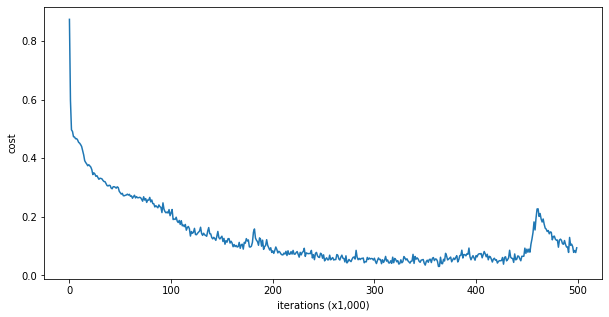

In [37]:
import matplotlib.pyplot as plt

# plot the cost
plt.plot(loss_list)
plt.ylabel('cost')
plt.xlabel('iterations (x1,000)')
plt.show()

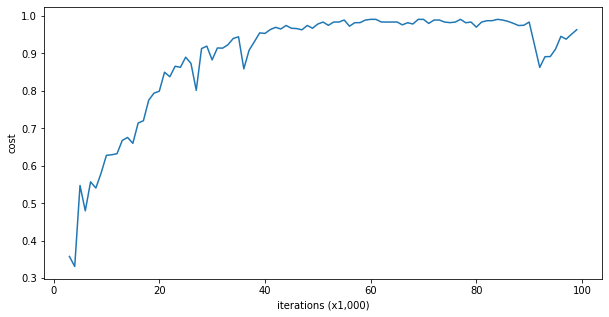

In [38]:
import matplotlib.pyplot as plt

# plot the cost
plt.plot(f_list)
plt.ylabel('cost')
plt.xlabel('iterations (x1,000)')
plt.show()

In [39]:
import glob

def load_model(directory):
    
    today = datetime.datetime.now().strftime("%x").replace("/","_")
    directory = "models/"+today+"/"+directory
    files = glob.glob(directory+"/*")
    models = []
    highest_f = 0
    highest_f_index = 0
    index = 0
    for file in files:
    
        model = LSTM_variable_input_v2(CODE_WEIGHT_METRIX, TITLE_WEIGHT_METRIX,
            HIDDEN_DIM,
            N_LAYERS, 
            BIDIRECTIONAL)
        model.to(device)
        

        checkpoint = torch.load(file)
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        val_f_measure = checkpoint['val_f_measure']
        
        if highest_f < val_f_measure:
            highest_f = val_f_measure
            highest_f_index = index
        index = index+1
        models.append(model)

    model = models[highest_f_index]
        
    return model,highest_f

directory = "17_20_06"

loaded_model, f = load_model(directory) 

In [40]:
loaded_model

LSTM_variable_input_v2(
  (code_embedding): Embedding(1818, 50)
  (title_embedding): Embedding(818, 50)
  (code_lstm): LSTM(50, 50, num_layers=2, dropout=0.3, bidirectional=True)
  (title_lstm): LSTM(50, 50, num_layers=2, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

In [41]:
f

0.9911189675331116

In [42]:
validation_metrics (loaded_model, test_dl)

tensor(279.)
tensor(3.)
tensor(1314.)
tensor(2.)


/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/nimmi/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/nimmi/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([598])) that is different to the input size (torch.Size([598, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


(0.017087815562554533,
 tensor(0.9969),
 {'precision': 0.9893617033958435,
  'recall': 0.9928825497627258,
  'f_measure': 0.9911189675331116,
  'accuracy': 0.9968711137771606})

In [43]:
pred_list = []
y_list = []
for x1,x2,y,l1,l2 in test_dl:
        x1 = x1.long()
        x2 = x2.long()
        y = y.long()
        y = y.flatten()
        y = torch.tensor(y, dtype=torch.float)  
        
        #x1,x2,y,l1,l2 = x1.to(device), x2.to(device), y.to(device), l1.to(device), l2.to(device)
        x1,x2,l1,l2 = x1.to(device), x2.to(device), l1.to(device), l2.to(device)

        
        y_hat = loaded_model(x1, x2,l1,l2)
        y_hat = y_hat.cpu()
        
        loss = nn.BCELoss()(y_hat, y)
        #loss = nn.BCEWithLogitsLoss()(y_hat, y.reshape(-1,1))
        #print(y_hat)
        pred = (y_hat>0.5).float()
        pred_list.append(pred)
        y_list.append(y)
        

/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [44]:
_pred_list=[]
for t in pred_list:
    _pred_list = _pred_list+t.reshape(-1).tolist()

In [45]:
_y_list=[]
for t in y_list:
    _y_list = _y_list+t.reshape(-1).tolist()

In [46]:
X_test_codes = codes[codes['is_golden']==1]['token_numbers'].values
X_test_titles = codes[codes['is_golden']==1]['title_token_numbers'].values
y_test = codes[codes['is_golden']==1]['is_idiomatic'].values

In [48]:
len(y_test)

1598

In [49]:
list(y_test[-10:])

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

In [50]:
codes.columns

Index(['ParentId_x', 'PostId', 'PostHistoryId', 'LocalId', 'PostBlockTypeId',
       'Length', 'LineCount', 'Content', 'is_idiomatic', 'is_golden',
       'is_golden_idiom', 'text', 'tokens', 'Id', 'PostTypeId',
       'AcceptedAnswerId', 'ParentId_y', 'CreationDate', 'DeletionDate',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'title_tokens',
       'QuestionScore', 'ParentId', 'AcceptedAnswerScore', 'Score',
       'code_length', 'token_numbers', 'title_token_numbers'],
      dtype='object')

In [51]:
val_data = codes.loc[codes['is_golden']==1]
val_data['pred']=_pred_list
val_data['y']=_y_list
d = val_data[['Title','Content','Score', 'AcceptedAnswerScore','pred','y','ParentId_x','PostId','LocalId','AcceptedAnswerId','is_idiomatic']]

/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nimmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
print(len(d[d['is_idiomatic']==d['y']]))
print(len(d)) #sanity check passed :P

1598
1598


In [53]:
i=0

id_list = []

for tupl in d.values:
    title = tupl[0]
    content = tupl[1]
    score = tupl[2]
    acceptedAnswerScore = tupl[3]
    pred = tupl[4]
    y = tupl[5]
    parentId = tupl[6]
    postId = tupl[7]
    localId = tupl[8]
    acceptedAnswerId = tupl[9]
    if((pred==1)and(acceptedAnswerScore<=score)):
        print("----------------------------------------------")
        print("----------------------------------------------")
        print(title)
        print("https://stackoverflow.com/questions/"+str(parentId))
        #print("Y: "+str(y))
        print("Score: "+str(score))
        print("PostId: "+str(postId))
        print("LocalId: "+str(localId))
        print("AcceptedAnswerScore: "+str(acceptedAnswerScore))
        print("AcceptedAnswer: "+str(acceptedAnswerId==postId))
        print("AcceptedAnswer: "+str(acceptedAnswerId))
        #print("Predicted: "+str(pred))
        print("----------------------------------------------")
        
        for line in content.split(SEPARATOR):
            print(line)
        id_list.append(postId)
        i=i+1
        
print(str(i)+" code idioms detected")

----------------------------------------------
----------------------------------------------
JavaScript for...in vs for
https://stackoverflow.com/questions/242841
Score: 545
PostId: 242888
LocalId: 2
AcceptedAnswerScore: 545
AcceptedAnswer: True
AcceptedAnswer: 242888.0
----------------------------------------------
    for (var i = 0; i < a.length; i++)
       //do stuff with a[i]
----------------------------------------------
----------------------------------------------
JavaScript for...in vs for
https://stackoverflow.com/questions/242841
Score: 545
PostId: 242888
LocalId: 4
AcceptedAnswerScore: 545
AcceptedAnswer: True
AcceptedAnswer: 242888.0
----------------------------------------------
    for (var key in o)
      //do stuff with o[key]
----------------------------------------------
----------------------------------------------
Get the name of an object's type
https://stackoverflow.com/questions/332422
Score: 1527
PostId: 332429
LocalId: 4
AcceptedAnswerScore: 1527
AcceptedA

In [64]:
golden_set.loc[golden_set['PostId'].map(lambda x: x in id_list)]

,ParentId,PostId,PostHistoryId,LocalId,PostBlockTypeId,Length,IsIdiom,LineCount,Content
974,242841,242888,19036846,2,2,66,1,2,for (var i = 0; i < a.length; i++)&#xD;&#x...
976,242841,242888,19036846,4,2,51,1,2,for (var key in o)&#xD;&#xA; //do stu...
1420,332422,332429,166319667,2,2,239,0,5,Object.prototype.getName = function() { &#...
1422,332422,332429,166319667,4,2,70,1,2,"var myArray = [1,2,3];&#xD;&#xA; (myArr..."
1426,332422,332429,166319667,8,2,116,0,3,function a() { this.foo = 1;}&#xD;&#xA; ...
...,...,...,...,...,...,...,...,...,...
31292,13833204,13833241,33074213,1,2,116,1,4,var jsonVariable = {};&#xD;&#xA; for(va...
32204,14636536,14636652,163252848,2,2,118,1,4,"if (data === parseInt(data, 10))&#xD;&#xA;..."
40243,22658488,22658584,76355388,2,2,235,1,7,var a = {};&#xD;&#xA; Object.defineProp...
48654,14723848,35167699,143240984,2,2,94,1,4,var arr = [1];&#xD;&#xA; var newItems =...


In [81]:
validation_metrics (load_model, train_dl)

AttributeError: 'function' object has no attribute 'eval'